#Download data

In [1]:
!mkdir /content/datasets
!mkdir /content/datasets/xView
!mkdir /content/datasets/xView/images

In [2]:
!cp "/content/drive/MyDrive/Leaders of Digital/Workshop 2/train_images.zip" "/content/datasets/xView"

In [3]:
!cp "/content/drive/MyDrive/Leaders of Digital/Workshop 2/train_labels.zip" "/content/datasets/xView"

In [4]:
!unzip /content/datasets/xView/train_labels.zip -d /content/datasets/xView

Archive:  /content/datasets/xView/train_labels.zip
  inflating: /content/datasets/xView/xView_train.geojson  


In [5]:
!jar xf /content/datasets/xView/train_images.zip

In [ ]:
import shutil
import os

In [ ]:
PATH_TO_IMAGES = '/content/train_images'
TARGET_DIR = '/content/datasets/xView/images'

file_names = os.listdir(PATH_TO_IMAGES)
    
for file_name in file_names:
    shutil.move(os.path.join(PATH_TO_IMAGES, file_name), TARGET_DIR)

In [ ]:
!rm -r /content/train_images
!rm -r /content/sample_data
!rm -r /content/__MACOSX

#Show sample

In [ ]:
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
from PIL import Image
import cv2
from pathlib import Path
import os
import json
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

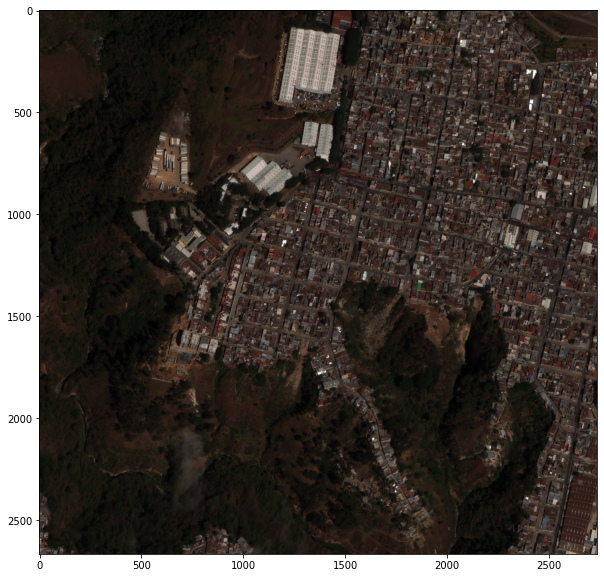

In [ ]:
image = cv2.imread('/content/datasets/xView/images/2355.tif')
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
with open('/content/datasets/xView/xView_train.geojson') as f:
    data = json.load(f)

In [ ]:
image.shape

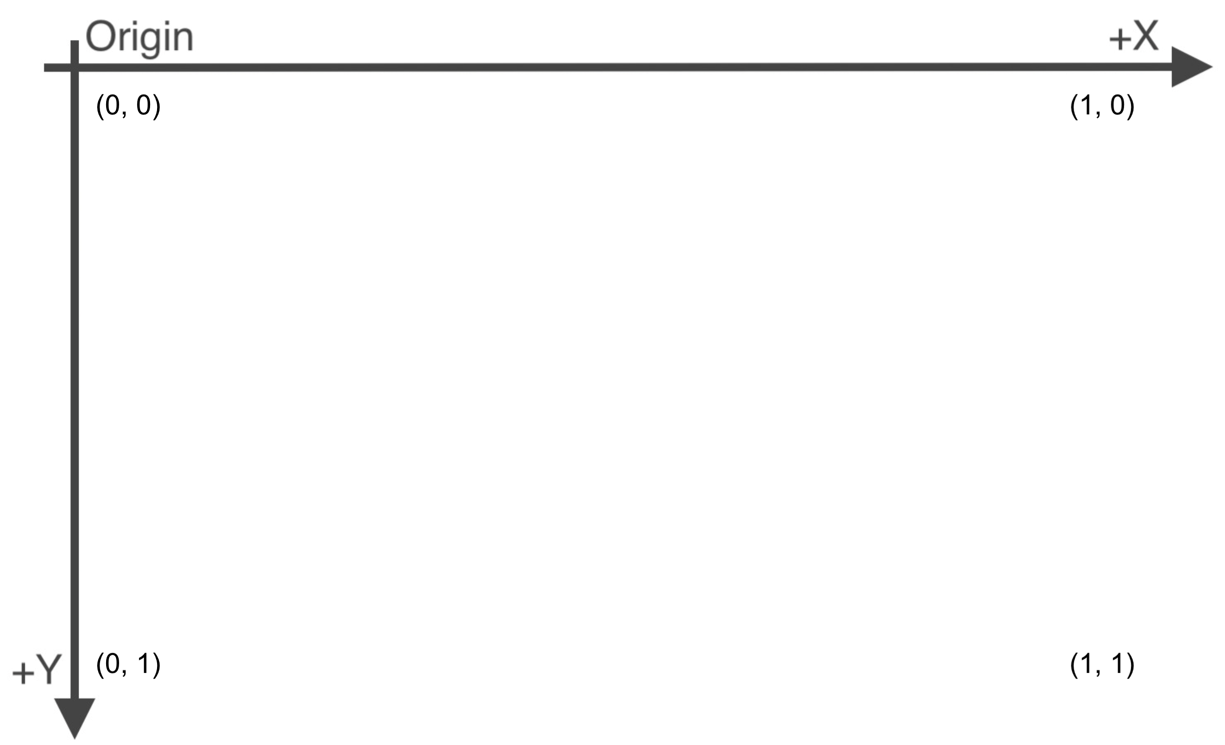

In [ ]:
data['features'][0]

In [ ]:
img_coordinates = []
for features in data['features']:
  if features['properties']['image_id'] == '2355.tif':
    bounds_imcoords = features['properties']['bounds_imcoords']
    img_coordinates.append(bounds_imcoords)

In [ ]:
for coordinates in img_coordinates:
    bounds_imcoords = data['features'][0]['properties']['bounds_imcoords'].split(',')
    x_1 = int(bounds_imcoords[0])
    y_1 = int(bounds_imcoords[1])
    x_2 = int(bounds_imcoords[2])
    y_2 = int(bounds_imcoords[3])
    cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (255,0,0), 2)

In [ ]:
image = cv2.imread('/content/datasets/xView/images/2355.tif')
bounds_imcoords = img_coordinates[1599].split(',')
x_1 = int(bounds_imcoords[0])
y_1 = int(bounds_imcoords[1])
x_2 = int(bounds_imcoords[2])
y_2 = int(bounds_imcoords[3])
cv2.rectangle(image, (x_1, y_1), (x_2, y_2), (255,0,0), 1)
cv2_imshow(image)

Output hidden; open in https://colab.research.google.com to view.

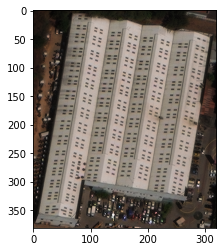

In [ ]:
img = plt.imread('/content/datasets/xView/images/2355.tif')
cropped_image = img[y_1:y_2, x_1:x_2]
plt.imshow(cropped_image)

#Yolo dataset preparation

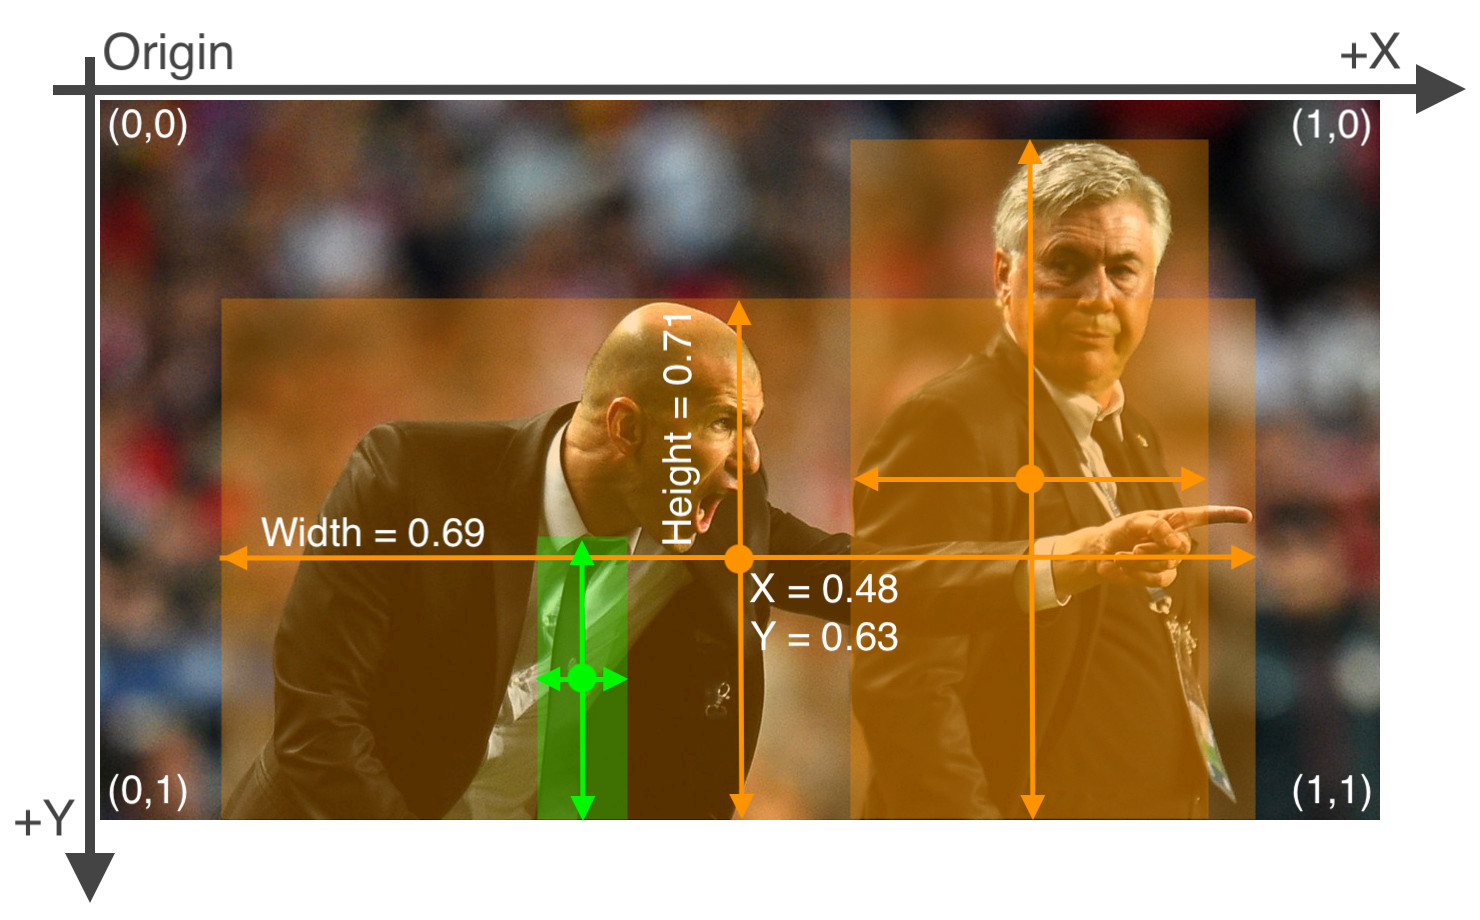

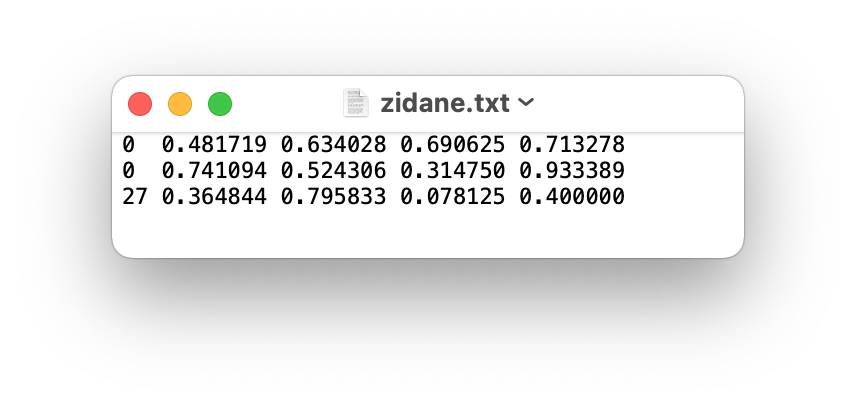

In [ ]:
!mkdir /content/datasets/xView/labels

In [ ]:
path_to_images = '/content/datasets/xView/images'

In [ ]:
labels = '/content/datasets/xView/labels'

In [ ]:
import sys
import random

In [ ]:
target_classes = {
    71: 'Hut/Tent', 
    72: 'Shed',
    73: 'Building',
    74: 'Aircraft Hangar' ,
    76: 'Damaged Building',
    77: 'Facility'
}

In [ ]:
class2index = {
    71: 0, 
    72: 1,
    73: 2,
    74: 3 ,
    76: 4,
    77: 5
}

In [ ]:
def clip_coords(boxes, shape):
    boxes[:, [0, 2]] = boxes[:, [0, 2]].clip(0, shape[1])  # x1, x2
    boxes[:, [1, 3]] = boxes[:, [1, 3]].clip(0, shape[0])  # y1, y2

    return boxes

def xyxy2xywhn(x, w=640, h=640, clip=False, eps=0.0):
    # Convert nx4 boxes from [x1, y1, x2, y2] to [x, y, w, h] normalized where xy1=top-left, xy2=bottom-right
    if clip:
        clip_coords(x, (h - eps, w - eps))  # warning: inplace clip
    y = np.copy(x)
    y[:, 0] = ((x[:, 0] + x[:, 2]) / 2) / w  # x center
    y[:, 1] = ((x[:, 1] + x[:, 3]) / 2) / h  # y center
    y[:, 2] = (x[:, 2] - x[:, 0]) / w  # width
    y[:, 3] = (x[:, 3] - x[:, 1]) / h  # height
    return y

In [ ]:
shapes = {}
for feature in tqdm(data['features']):
    p = feature['properties']
    if p['bounds_imcoords']:
        id = p['image_id']
        file = os.path.join(path_to_images, id)
        if os.path.exists(file) and p['type_id'] in target_classes.keys():
            try:
                box = np.array([int(num) for num in p['bounds_imcoords'].split(",")])
                cls = p['type_id']
                cls = class2index[int(cls)]
                if id not in shapes:
                    shapes[id] = Image.open(file).size
                box = xyxy2xywhn(box[None].astype(np.float), w=shapes[id][0], h=shapes[id][1], clip=True)
                with open(os.path.join(labels, Path(id).with_suffix('.txt')), 'a') as f:
                    f.write(f"{cls} {' '.join(f'{x:.6f}' for x in box[0])}\n")  # write label.txt
            except Exception as e:
              print(f'WARNING: skipping one label for {file}: {e}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/601937 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
IMG_FORMATS = 'bmp', 'dng', 'jpeg', 'jpg', 'mpo', 'png', 'tif', 'tiff', 'webp'

In [ ]:
def img2label_paths(img_paths):
    sa, sb = f'{os.sep}images{os.sep}', f'{os.sep}labels{os.sep}'  # /images/, /labels/ substrings
    return [sb.join(x.rsplit(sa, 1)).rsplit('.', 1)[0] + '.txt' for x in img_paths]

In [ ]:
def autosplit(path, weights, annotated_only=False):
    path = Path(path)
    files = sorted(x for x in path.rglob('*.*') if x.suffix[1:].lower() in IMG_FORMATS)  # image files only
    n = len(files)
    random.seed(0)
    indices = random.choices([0, 1, 2], weights=weights, k=n)

    txt = ['autosplit_train.txt', 'autosplit_val.txt', 'autosplit_test.txt']

    print(f'Autosplitting images from {path}' + ', using *.txt labeled images only' * annotated_only)
    for i, img in tqdm(zip(indices, files), total=n):
        if not annotated_only or Path(img2label_paths([str(img)])[0]).exists():  # check label
            with open(path.parent / txt[i], 'a') as f:
                f.write('./' + img.relative_to(path.parent).as_posix() + '\n') 

In [ ]:
autosplit('/content/datasets/xView/images', weights=(0.9, 0.1, 0.0))

Autosplitting images from /content/datasets/xView/images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/846 [00:00<?, ?it/s]

#Train Yolo

Need to create yml file with fillowing params

path: /content/datasets/xView

train: autosplit_train.txt

val: autosplit_val.txt

nc: 6

names: ['Hut/Tent', 'Shed', 'Building', 'Aircraft Hangar', 'Damaged Building', 'Facility']

In [ ]:
!git clone https://github.com/ultralytics/yolov5
!cd yolov5 && pip install -r requirements.txt

In [ ]:
!cp "/content/drive/MyDrive/Leaders of Digital/Workshop 2/xView.yaml" "/content/"  

In [ ]:
import sys
sys.path.append('/content/yolov5')

Аргументы:


**img**: размер входного изображения

**batch**: размер батча

**epochs**: число эпох обучения

**data**: путь к датасету

**weights**: путь к весам pretrained моделт

**cache**: кеширование изображений для ускорения обучения

In [ ]:
!cd /content/yolov5 && python train.py --batch 16 --epochs 150 --data /content/xView.yaml --weights yolov5m.pt --cache

train: weights=yolov5m.pt, cfg=, data=/content/xView.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=150, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-260-g724d5b2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, i

#Show training progress

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/yolov5/runs/train

#Run test predictions

In [ ]:
!mkdir /content/datasets/xView/test

In [ ]:
!cp "/content/drive/MyDrive/Leaders of Digital/Workshop 2/assets/istockphoto-594324970-640x640.jpg" /content/datasets/xView/test
!cp "/content/drive/MyDrive/Leaders of Digital/Workshop 2/assets/gmaps.png" /content/datasets/xView/test
!cp "/content/drive/MyDrive/Leaders of Digital/Workshop 2/assets/gmaps2.png" /content/datasets/xView/test

In [ ]:
!cd yolov5 && python detect.py --weights /content/yolov5/runs/train/exp4/weights/best.pt --conf 0.1 --source /content/datasets/xView/test

detect: weights=['/content/yolov5/runs/train/exp4/weights/best.pt'], source=/content/datasets/xView/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-260-g724d5b2 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla V100-SXM2-16GB, 16160MiB)

Fusing layers... 
Model summary: 290 layers, 20873139 parameters, 0 gradients
image 1/3 /content/datasets/xView/test/gmaps.png: 448x640 2 Buildings, Done. (0.019s)
image 2/3 /content/datasets/xView/test/gmaps2.png: 512x640 7 Buildings, Done. (0.018s)
image 3/3 /content/datasets/xView/test/istockphoto-594324970-640x640.jpg: 384x640 107 Buildings, Done. (0.021s)
Speed: 0.6ms pre-process, 19.2ms inference, 1.2ms 

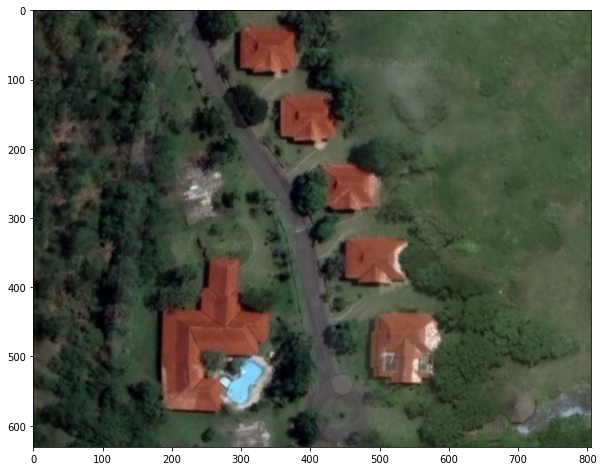

In [ ]:
image = cv2.imread('/content/datasets/xView/test/gmaps2.png')
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

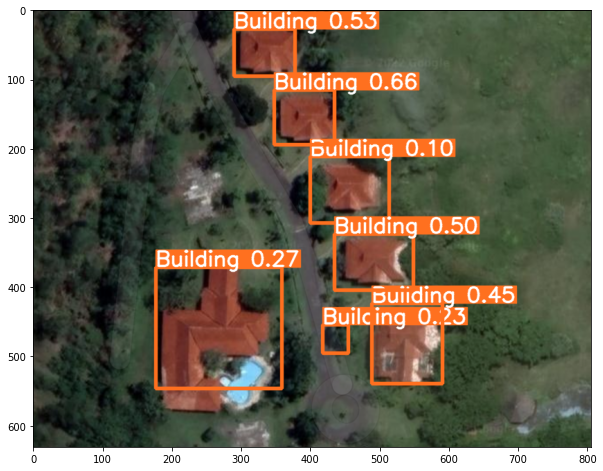

In [ ]:
image = cv2.imread('/content/yolov5/runs/detect/exp5/gmaps2.png')
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()